In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [6]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from pycaret.regression import RegressionExperiment

from heisenberg import (
    extract_probs,
)

In [5]:
# Load parameters
# CURRENT_TIME = "2024-12-10T15:41Z"
# path = f"./data/{CURRENT_TIME}"
path = "data/2024-12-13T08:56Z"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

for key, value in params_object.items():
    print(f"{key}: {value}")

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

for key, value in params.items():
    print(f"{key}: {value}")

graphs: [<networkx.classes.graph.Graph object at 0x7f9adf7e1c10>, <networkx.classes.graph.Graph object at 0x7f9adfd056d0>, <networkx.classes.graph.Graph object at 0x7f9adf7e39d0>, <networkx.classes.graph.Graph object at 0x7f9adf7ec7d0>, <networkx.classes.graph.Graph object at 0x7f9adf7ed590>, <networkx.classes.graph.Graph object at 0x7f9adf7ee350>, <networkx.classes.graph.Graph object at 0x7f9adf7ef110>, <networkx.classes.graph.Graph object at 0x7f9adf7efed0>, <networkx.classes.graph.Graph object at 0x7f9adf7f8cd0>, <networkx.classes.graph.Graph object at 0x7f9adf7f9a90>, <networkx.classes.graph.Graph object at 0x7f9adf7fa850>, <networkx.classes.graph.Graph object at 0x7f9adf7fb610>, <networkx.classes.graph.Graph object at 0x7f9adf604410>, <networkx.classes.graph.Graph object at 0x7f9adf6051d0>, <networkx.classes.graph.Graph object at 0x7f9adf605f90>, <networkx.classes.graph.Graph object at 0x7f9adf606d50>, <networkx.classes.graph.Graph object at 0x7f9adf607b10>, <networkx.classes.grap

In [40]:
n_qubits = 4
n_samples = 55
backend_qpu_name = "ibmq_marrakesh"

path = "results/fourier_feature_sim"

## Plot probability

In [8]:
# Load the data as a json file
with open(f"{path}/probs_phase0_exact.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path}/probs_phase1_exact.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path}/probs_phase2_exact.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path}/probs_phase3_exact.json", "r") as f:
    probs_phase3_exact = json.load(f)

In [9]:
with open(f"{path}/probs_phase0_sim_noiseless.json", "r") as f:
    probs_phase0_sim = json.load(f)
with open(f"{path}/probs_phase1_sim_noiseless.json", "r") as f:
    probs_phase1_sim = json.load(f)
with open(f"{path}/probs_phase2_sim_noiseless.json", "r") as f:
    probs_phase2_sim = json.load(f)
with open(f"{path}/probs_phase3_sim_noiseless.json", "r") as f:
    probs_phase3_sim = json.load(f)

In [11]:
with open(f"{path}/probs_phase0_sim_noisy.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path}/probs_phase1_sim_noisy.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path}/probs_phase2_sim_noisy.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path}/probs_phase3_sim_noisy.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

In [9]:
with open(f"{path}/probs_phase0_nmit.json", "r") as f:
    probs_phase0_nmit = json.load(f)
with open(f"{path}/probs_phase1_nmit.json", "r") as f:
    probs_phase1_nmit = json.load(f)
with open(f"{path}/probs_phase2_nmit.json", "r") as f:
    probs_phase2_nmit = json.load(f)
with open(f"{path}/probs_phase3_nmit.json", "r") as f:
    probs_phase3_nmit = json.load(f)

with open(f"{path}/probs_phase0_mit.json", "r") as f:
    probs_phase0_mit = json.load(f)
with open(f"{path}/probs_phase1_mit.json", "r") as f:
    probs_phase1_mit = json.load(f)
with open(f"{path}/probs_phase2_mit.json", "r") as f:
    probs_phase2_mit = json.load(f)
with open(f"{path}/probs_phase3_mit.json", "r") as f:
    probs_phase3_mit = json.load(f)

In [10]:
with open(f"{path}/successful_job_ids_and_samples.json", "r") as f:
    successful_job_ids_and_samples = json.load(f)

In [14]:
# For debugging
dummy_successful_job_ids_and_samples = {}
for i in range(n_samples):
    dummy_successful_job_ids_and_samples[f"sample{i}"] = None

successful_job_ids_and_samples = dummy_successful_job_ids_and_samples

In [15]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_job_ids_and_samples.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_job_ids_and_samples.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_job_ids_and_samples.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_job_ids_and_samples.keys()
)

In [16]:
probs_phase0_sim_extracted = extract_probs(
    probs_phase0_sim, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_extracted = extract_probs(
    probs_phase1_sim, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_extracted = extract_probs(
    probs_phase2_sim, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_extracted = extract_probs(
    probs_phase3_sim, successful_job_ids_and_samples.keys()
)

In [17]:
probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_job_ids_and_samples.keys()
)

In [14]:
probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_job_ids_and_samples.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_job_ids_and_samples.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_job_ids_and_samples.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_job_ids_and_samples.keys()
)

probs_phase0_mit_extracted = extract_probs(
    probs_phase0_mit, successful_job_ids_and_samples.keys()
)
probs_phase1_mit_extracted = extract_probs(
    probs_phase1_mit, successful_job_ids_and_samples.keys()
)
probs_phase2_mit_extracted = extract_probs(
    probs_phase2_mit, successful_job_ids_and_samples.keys()
)
probs_phase3_mit_extracted = extract_probs(
    probs_phase3_mit, successful_job_ids_and_samples.keys()
)

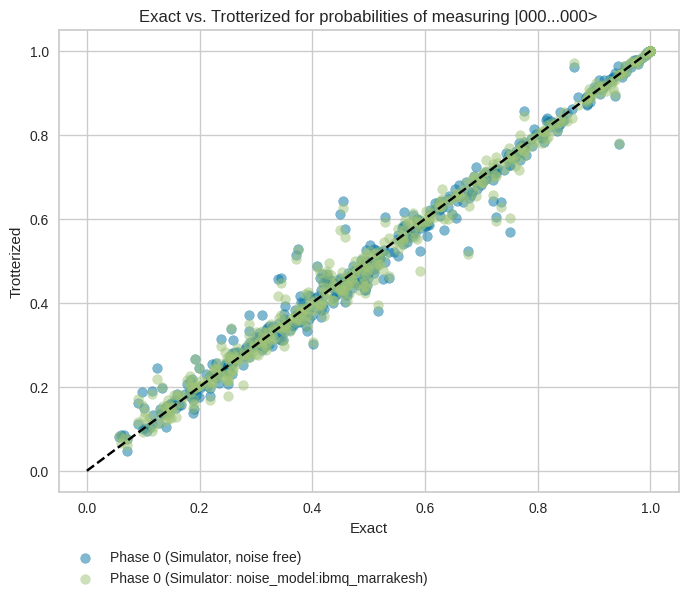

In [20]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_noisy_extracted,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_nmit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_mit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

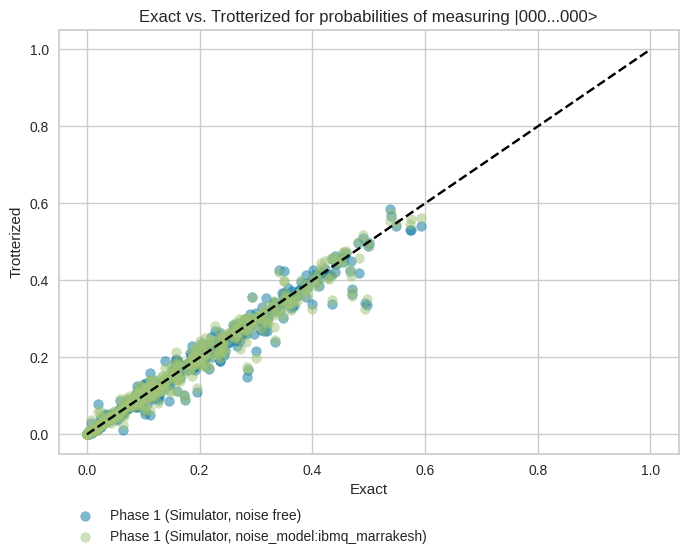

In [21]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_noisy_extracted,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_nmit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_mit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

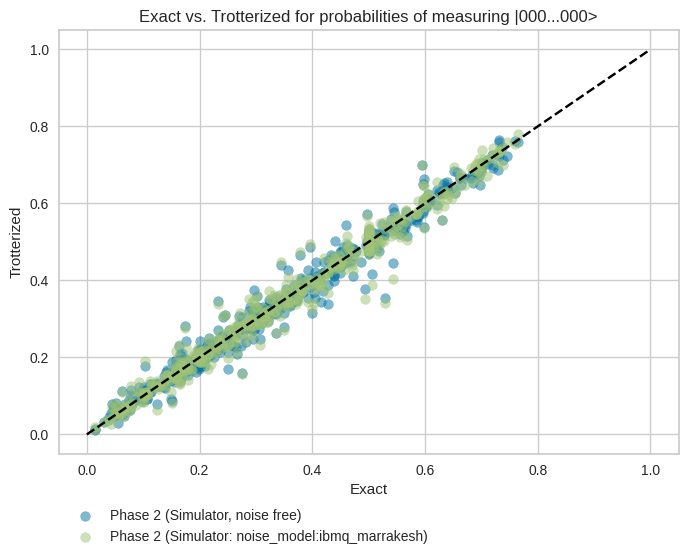

In [22]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_noisy_extracted,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_nmit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_mit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

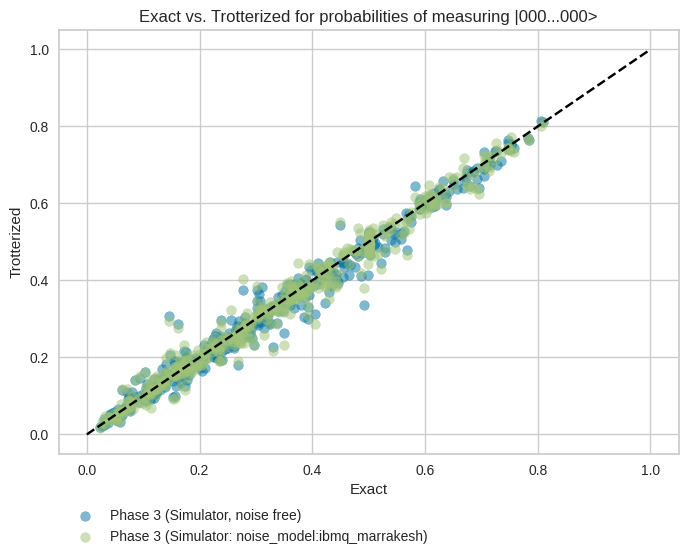

In [23]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_noisy_extracted,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_nmit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_mit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [26]:
feature_exact_df = pd.read_json(f"{path}/feature_exact.json")

In [27]:
feature_sim_noiseless_df = pd.read_json(f"{path}/feature_sim_noiseless.json")

In [29]:
feature_sim_noisy_df = pd.read_json(f"{path}/feature_sim_noisy.json")

In [22]:
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

In [31]:
# For debugging
data_mit_df = feature_exact_df

In [24]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

In [25]:
data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

In [26]:
data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

In [27]:
data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

### Feature check

In [32]:
print("Exact")
display(feature_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,f_5 Re,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,expected_value
0,0,1,0.718041,0.383606,0.195441,0.340886,-0.061805,0.044172,-0.059755,-0.029632,-0.207918,0.171675,-0.599948,0.220433,-0.802551,-0.096272,-0.490669,-0.402475,13.899220
1,1,1,0.533219,0.556411,-0.176896,0.330914,-0.190092,-0.225399,0.255385,-0.298390,0.379184,-0.034141,0.197245,-0.017423,0.179823,-0.100772,0.162744,0.154607,28.585213
2,2,1,0.778346,-0.246211,0.301691,-0.343953,-0.040665,-0.286528,-0.018982,-0.205568,0.232292,-0.226135,0.357286,-0.330143,0.130089,-0.371267,-0.320885,-0.229954,2.653082
3,3,1,0.771926,0.295819,0.242453,0.300258,-0.238066,-0.049999,-0.378689,-0.537668,-0.151334,-0.827320,0.207169,-0.716856,0.387829,-0.285992,0.243577,0.167489,7.222891
4,4,1,0.963873,-0.163293,0.863299,-0.319218,0.719016,-0.457295,0.557826,-0.563322,0.404492,-0.622343,0.275721,-0.624241,0.178362,-0.569336,0.111796,-0.471004,0.865078
5,5,1,0.652979,-0.392155,0.091830,-0.237883,-0.061567,0.099905,-0.026271,0.051280,-0.279651,-0.158154,-0.556160,-0.021664,-0.312819,0.214764,0.192527,-0.045099,1.138950
6,6,1,0.801611,0.252730,0.416358,0.227315,0.199764,0.024042,0.200110,-0.014849,0.134899,0.227875,-0.180995,0.480511,-0.546562,0.444028,-0.624683,0.188821,9.060659
7,7,1,0.831500,-0.164043,0.476650,-0.340292,0.220555,-0.422985,0.190423,-0.288624,0.285566,0.003609,0.367036,0.211216,0.419182,0.156153,0.486711,-0.076606,4.367027
8,8,1,0.855184,0.356904,0.484418,0.563724,0.050315,0.535060,-0.258042,0.286645,-0.308841,-0.072210,-0.084979,-0.386555,0.310219,-0.522861,0.700787,-0.425811,4.566077
9,9,1,0.783503,0.073778,0.339573,0.228951,0.056574,0.356156,0.097964,0.268420,0.292518,-0.018056,0.402635,-0.237244,0.390137,-0.168979,0.364223,0.084275,3.720380


In [33]:
print("Simulator (noise free)")
display(feature_sim_noiseless_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,f_5 Re,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,expected_value
0,0,1,0.706114,0.375307,0.213255,0.321226,-0.078159,0.028074,-0.078442,-0.011719,-0.277071,0.152880,-0.618868,0.229090,-0.813039,-0.070392,-0.506908,-0.380469,13.899220
1,1,1,0.548074,0.518690,-0.177835,0.306601,-0.298964,-0.120413,0.164723,-0.322467,0.386129,-0.112398,0.361931,-0.012191,0.199151,-0.066338,0.066297,-0.045714,28.585213
2,2,1,0.798557,-0.227124,0.310811,-0.327270,-0.063735,-0.252757,-0.071320,-0.223143,0.135842,-0.323222,0.324523,-0.383766,0.194756,-0.364917,-0.192686,-0.193005,2.653082
3,3,1,0.780524,0.313610,0.267600,0.281358,-0.222763,-0.057137,-0.355453,-0.546363,-0.170823,-0.816208,0.169378,-0.726435,0.371905,-0.293285,0.236820,0.125050,7.222891
4,4,1,0.963521,-0.157379,0.891336,-0.306115,0.721329,-0.435237,0.527981,-0.575506,0.388149,-0.601289,0.310785,-0.642202,0.175477,-0.565267,0.168088,-0.448392,0.865078
5,5,1,0.649238,-0.413218,0.077597,-0.196780,-0.094918,0.092015,-0.024808,0.056088,-0.303801,-0.132463,-0.549042,-0.009270,-0.329695,0.175114,0.161920,-0.064582,1.138950
6,6,1,0.796614,0.267551,0.402553,0.229713,0.154019,0.037945,0.201685,-0.008138,0.122291,0.197506,-0.157928,0.510592,-0.545015,0.456502,-0.607982,0.228628,9.060659
7,7,1,0.822635,-0.146970,0.468147,-0.307185,0.185040,-0.354731,0.174050,-0.297389,0.307787,0.016637,0.407578,0.297709,0.385245,0.308603,0.328509,0.170909,4.367027
8,8,1,0.869803,0.304427,0.514823,0.565772,0.094597,0.526839,-0.238243,0.306222,-0.346433,-0.019040,-0.114129,-0.323921,0.264039,-0.490373,0.655381,-0.480453,4.566077
9,9,1,0.779745,0.034774,0.297242,0.209769,-0.015450,0.301629,0.089065,0.304836,0.276429,0.076773,0.416139,-0.289103,0.355037,-0.291594,0.196299,-0.104519,3.720380


In [34]:
print("Simulator (noisy)")
display(feature_sim_noisy_df)

Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,f_5 Re,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,expected_value
0,0,1,0.762443,0.390774,0.219918,0.301806,-0.066307,0.037971,-0.100064,-0.056115,-0.208400,0.162605,-0.597200,0.217222,-0.818461,-0.075483,-0.491596,-0.367544,13.899220
1,1,1,0.554864,0.528341,-0.154230,0.302606,-0.314515,-0.145242,0.116837,-0.282196,0.408194,-0.076577,0.361957,-0.010007,0.191075,-0.088769,0.073500,-0.012819,28.585213
2,2,1,0.805549,-0.210274,0.283580,-0.363750,-0.056023,-0.273511,-0.061820,-0.277999,0.152797,-0.327964,0.315845,-0.362774,0.175323,-0.355912,-0.234724,-0.177719,2.653082
3,3,1,0.767661,0.291075,0.225163,0.301857,-0.210771,-0.053869,-0.361595,-0.540001,-0.176058,-0.829643,0.214819,-0.699677,0.373731,-0.284254,0.232181,0.154982,7.222891
4,4,1,0.969251,-0.162120,0.864120,-0.297868,0.735042,-0.418243,0.558861,-0.567936,0.422811,-0.602339,0.270026,-0.617420,0.201116,-0.574968,0.139691,-0.468957,0.865078
5,5,1,0.654839,-0.360410,0.120942,-0.198152,-0.031365,0.081105,-0.054989,0.044133,-0.291418,-0.152742,-0.569872,-0.025901,-0.320176,0.197168,0.186186,-0.077812,1.138950
6,6,1,0.786622,0.257434,0.435218,0.194963,0.158034,0.007876,0.195341,-0.014890,0.181701,0.235429,-0.171679,0.495887,-0.558174,0.496007,-0.622511,0.185453,9.060659
7,7,1,0.809955,-0.135564,0.465281,-0.288164,0.166077,-0.334459,0.156480,-0.263373,0.292353,0.016196,0.377182,0.311389,0.396964,0.314542,0.352797,0.187551,4.367027
8,8,1,0.846253,0.329826,0.482781,0.573850,0.054153,0.519739,-0.251339,0.284186,-0.297941,-0.021668,-0.137556,-0.326938,0.262423,-0.481679,0.632759,-0.433534,4.566077
9,9,1,0.796249,0.031631,0.349795,0.202137,-0.016758,0.329392,0.058139,0.250489,0.269407,0.062679,0.413283,-0.271324,0.307626,-0.301741,0.244737,-0.111343,3.720380


In [33]:
print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

no mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,expected_value
0,0,0.856399,0.379872,-0.174568,-0.078717,-0.223972,-0.065818,-0.438957,0.242487,-0.264318,...,-0.032617,-0.405848,0.175482,-0.180304,0.039267,0.083858,-0.119063,0.329626,0.060625,2.653082
1,1,0.863172,0.712256,-0.222984,0.484934,-0.386381,0.287193,-0.421108,0.214526,-0.429065,...,-0.282439,0.111165,-0.128659,0.101498,-0.043748,0.165890,-0.064451,0.265827,-0.151564,0.865078
2,2,0.852850,0.206599,-0.229355,-0.033527,0.119193,-0.269301,-0.091643,-0.265075,0.108174,...,-0.306954,-0.142990,-0.479818,-0.074508,-0.058070,-0.093036,0.107949,-0.062635,0.559754,1.138950
3,3,0.884527,0.434806,-0.111033,0.067506,-0.261733,0.197523,-0.080843,0.330599,0.396281,...,0.497084,0.053674,-0.092413,0.324689,0.083715,0.359439,0.175253,0.025587,-0.039859,4.367027
4,4,0.865765,0.488672,0.395245,-0.063155,0.329951,-0.208477,0.044257,0.114091,-0.266913,...,-0.295100,0.655832,0.010295,0.281593,0.286991,-0.043852,0.268327,-0.128666,0.016263,4.566077
5,5,0.847938,0.285698,-0.013091,-0.031821,0.222825,0.150439,0.222087,0.271264,-0.333115,...,-0.416660,0.009592,0.042969,0.176202,-0.331650,0.250258,-0.396509,0.122560,-0.010078,3.720380
6,6,0.849071,0.554542,-0.253599,0.131824,-0.403920,0.079901,-0.369042,0.121698,-0.067666,...,0.073287,-0.186281,-0.157061,-0.176084,-0.046551,-0.205503,0.233455,-0.204654,0.439101,1.711405
7,7,0.847654,0.478527,-0.298953,0.057427,-0.020238,0.100017,0.262145,0.170249,0.141205,...,-0.052587,-0.031596,-0.031785,0.154851,-0.129038,0.138929,-0.495093,-0.124508,-0.555493,0.920606
8,8,0.912786,0.327883,-0.282926,0.010642,0.063912,-0.181755,-0.242567,-0.619519,-0.021782,...,0.122673,-0.041467,-0.293105,-0.128387,0.009854,0.231769,0.062541,-0.065169,0.065164,1.084233
9,9,0.861408,0.513362,0.147119,0.009895,0.116322,-0.068013,0.123129,0.249928,0.286024,...,0.411072,0.016112,0.205603,-0.340211,-0.092209,-0.327593,-0.197933,-0.055861,0.047961,3.526609


mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_5 Im,f_6 Re,f_6 Im,f_7 Re,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,expected_value
0,0,0.838623,0.372054,-0.170947,-0.077033,-0.219295,-0.064369,-0.429910,0.237327,-0.258718,...,-0.031876,-0.397281,0.171876,-0.176602,0.038431,0.082011,-0.116690,0.322599,0.059254,2.653082
1,1,0.844971,0.697600,-0.218406,0.474904,-0.378405,0.281237,-0.412420,0.210229,-0.420103,...,-0.276495,0.108831,-0.126029,0.099417,-0.043085,0.162471,-0.063213,0.260398,-0.148362,0.865078
2,2,0.834961,0.202400,-0.224573,-0.032818,0.116846,-0.263668,-0.089655,-0.259560,0.105942,...,-0.300420,-0.140077,-0.469993,-0.072830,-0.057149,-0.091113,0.105686,-0.061238,0.548285,1.138950
3,3,0.865967,0.425851,-0.108769,0.066024,-0.256184,0.193331,-0.079051,0.323746,0.388222,...,0.486947,0.052477,-0.090498,0.317977,0.082039,0.351879,0.171380,0.025009,-0.039147,4.367027
4,4,0.847656,0.478610,0.386887,-0.061757,0.323101,-0.204157,0.043310,0.111774,-0.261268,...,-0.288897,0.642349,0.010082,0.275892,0.281157,-0.042919,0.262728,-0.125920,0.015740,4.566077
5,5,0.829834,0.279720,-0.012782,-0.031159,0.218361,0.147467,0.217553,0.265459,-0.326353,...,-0.408063,0.009195,0.042093,0.172517,-0.324743,0.245138,-0.388330,0.120095,-0.009702,3.720380
6,6,0.831299,0.543041,-0.248330,0.129134,-0.395369,0.078296,-0.361488,0.119221,-0.066275,...,0.071736,-0.182411,-0.153823,-0.172423,-0.045476,-0.201188,0.228486,-0.200276,0.429981,1.711405
7,7,0.830078,0.468769,-0.292635,0.056399,-0.019634,0.097934,0.256791,0.166670,0.138339,...,-0.051358,-0.030996,-0.031260,0.151511,-0.126511,0.136056,-0.484973,-0.121948,-0.544468,0.920606
8,8,0.893799,0.321233,-0.277057,0.010495,0.062717,-0.178002,-0.237514,-0.606565,-0.021287,...,0.120114,-0.040616,-0.287054,-0.125761,0.009550,0.227099,0.061387,-0.063691,0.063877,1.084233
9,9,0.843262,0.502656,0.144241,0.009634,0.113849,-0.066622,0.120424,0.244919,0.280192,...,0.402525,0.015730,0.201382,-0.333055,-0.090311,-0.320844,-0.193981,-0.054622,0.047095,3.526609


## Exact

In [35]:
train_size = 0.8
session_id = 42
sort = "MSE"

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 19)"
4,Transformed data shape,"(55, 18)"
5,Transformed train set shape,"(44, 18)"
6,Transformed test set shape,"(11, 18)"
7,Ignore features,2
8,Numeric features,17
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0001,0.0000,0.0001,1.0000,0.0000,0.0000,0.1390
huber,Huber Regressor,0.1318,0.0604,0.1898,0.9911,0.0289,0.0330,0.0040
par,Passive Aggressive Regressor,0.6354,0.6776,0.7768,0.5915,0.1688,0.2257,0.0030
ridge,Ridge Regression,1.2902,6.6988,1.8801,0.2963,0.2298,0.3275,0.1210
et,Extra Trees Regressor,1.5170,6.9754,2.1625,-0.0635,0.3774,0.6207,0.0110
gbr,Gradient Boosting Regressor,1.6525,7.8543,2.3738,0.1409,0.4457,0.7591,0.0070
br,Bayesian Ridge,1.2407,7.8880,1.8073,-0.0028,0.2459,0.3728,0.0040
rf,Random Forest Regressor,2.2025,13.0759,3.1194,-0.2635,0.4999,0.9124,0.0130
ada,AdaBoost Regressor,1.8621,20.0820,3.0172,-0.0514,0.4498,0.9179,0.0070
knn,K Neighbors Regressor,2.4991,22.3291,3.7748,-0.3122,0.4472,0.6388,0.0050


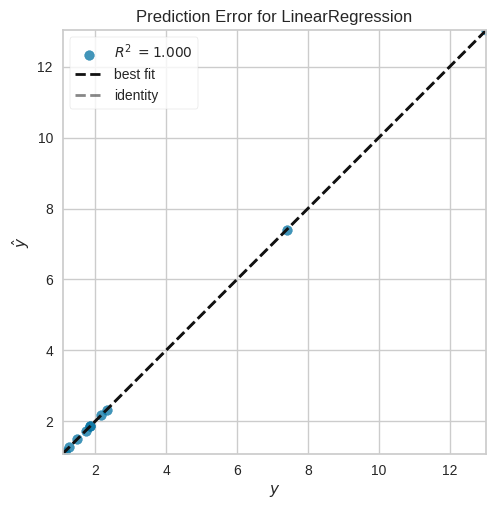

In [36]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=feature_exact_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)

best_exact = s_exact.compare_models(turbo=True, sort=sort)
s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 19)"
4,Transformed data shape,"(55, 18)"
5,Transformed train set shape,"(44, 18)"
6,Transformed test set shape,"(11, 18)"
7,Ignore features,2
8,Numeric features,17
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.9436,1.6051,1.1808,-0.0894,0.2490,0.3651,0.0030
lr,Linear Regression,1.0241,1.7738,1.2480,-0.3564,0.2940,0.4239,0.0040
huber,Huber Regressor,1.0966,2.7398,1.4613,-0.2141,0.2605,0.3833,0.0050
par,Passive Aggressive Regressor,1.4585,4.4740,1.8260,-0.4423,0.3398,0.6579,0.0030
ada,AdaBoost Regressor,1.2617,5.0302,1.7588,-0.2415,0.3456,0.5425,0.0070
gbr,Gradient Boosting Regressor,1.3847,6.7828,2.0638,0.3419,0.3790,0.5508,0.0070
et,Extra Trees Regressor,1.5665,7.8387,2.3162,-0.1950,0.4000,0.6630,0.0100
ridge,Ridge Regression,1.4269,8.0016,2.0688,0.3510,0.2477,0.3416,0.0020
dt,Decision Tree Regressor,1.9460,10.1505,2.7286,-2.1764,0.5093,0.7619,0.0030
rf,Random Forest Regressor,2.1510,11.0511,2.8887,-0.8295,0.4965,0.8788,0.0110


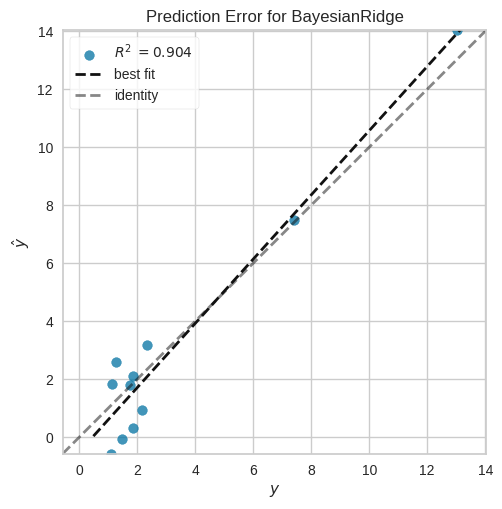

In [42]:
s_sim_noiseless = RegressionExperiment()
s_sim_noiseless.setup(
    data=feature_sim_noiseless_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)

best_sim_noiseless = s_sim_noiseless.compare_models(turbo=True, sort=sort)
s_sim_noiseless.plot_model(best_sim_noiseless, plot="error")

## Trotter (Simulation, Noisy)

In [48]:
def create_model_and_plot(
    experiment: RegressionExperiment,
    exact_experiment: RegressionExperiment,  # 比較用: non-Trotter シミュレータのノイズなしの結果
    sim_noiseless_experiment: RegressionExperiment,  # 比較用: Trotter シミュレータのノイズなしの結果
    reg_method=None,  # 回帰手法. "ada", "dt", "et", "gbr", "knn", "lar", "lightgbm", "lr", "mlp", "omp", "par", "ransac", "rf", "ridge", "svm", "xgboost"
) -> None:
    # モデルを作成
    if reg_method:  # 指定された回帰手法でモデルを作成
        model = experiment.create_model(reg_method, verbose=False)
        sim_model = sim_noiseless_experiment.create_model(reg_method, verbose=False)
    else:  # 指定されなければ最適なモデルを作成
        model = experiment.compare_models(turbo=True, sort=sort, verbose=False)
        sim_model = sim_noiseless_experiment.compare_models(
            turbo=True, sort=sort, verbose=False
        )

    # exact は最適なモデル (おそらく線形回帰) を作成
    exact_model = exact_experiment.compare_models(turbo=True, sort=sort, verbose=False)

    experiment.tune_model(model, optimize=sort, choose_better=True, verbose=False)
    exact_experiment.tune_model(
        exact_model, optimize=sort, choose_better=True, verbose=False
    )
    sim_noiseless_experiment.tune_model(
        sim_model, optimize=sort, choose_better=True, verbose=False
    )

    # 回帰手法の名前を取得
    reg_method = model.__class__.__name__
    exact_reg_method = exact_model.__class__.__name__
    sim_reg_method = sim_model.__class__.__name__

    # 予測
    pred = experiment.predict_model(model)
    x = pred["expected_value"].values.reshape(-1, 1)  # サンプル数 x 1
    y = pred["prediction_label"].values
    r2 = r2_score(x, y)
    mse = mean_squared_error(x, y)

    exact_pred = exact_experiment.predict_model(exact_model)
    exact_x = exact_pred["expected_value"].values.reshape(-1, 1)
    exact_y = exact_pred["prediction_label"].values
    exact_r2 = r2_score(exact_x, exact_y)
    exact_mse = mean_squared_error(exact_x, exact_y)

    sim_pred = sim_noiseless_experiment.predict_model(sim_model)
    sim_x = sim_pred["expected_value"].values.reshape(-1, 1)
    sim_y = sim_pred["prediction_label"].values
    sim_r2 = r2_score(sim_x, sim_y)
    sim_mse = mean_squared_error(sim_x, sim_y)

    # 回帰直線を計算
    linear_model = LinearRegression()
    linear_model.fit(x, y)
    slope = linear_model.coef_[0]
    intercept = linear_model.intercept_

    exact_linear_model = LinearRegression()
    exact_linear_model.fit(exact_x, exact_y)
    exact_slope = exact_linear_model.coef_[0]
    exact_intercept = exact_linear_model.intercept_

    sim_linear_model = LinearRegression()
    sim_linear_model.fit(sim_x, sim_y)
    sim_slope = sim_linear_model.coef_[0]
    sim_intercept = sim_linear_model.intercept_

    # プロット
    plt.figure(figsize=(8, 6))
    plt.scatter(
        x,
        y,
        alpha=0.5,
        color="green",
        label=f"{reg_method}, R2 = {r2:.2e}, MSE = {mse:.2e}",
    )
    plt.scatter(
        exact_x,
        exact_y,
        alpha=0.5,
        color="red",
        label=f"non-Trotter Sim: {exact_reg_method}, R2 = {exact_r2:.2e}, MSE = {exact_mse:.2e}",
    )
    plt.scatter(
        sim_x,
        sim_y,
        alpha=0.5,
        color="blue",
        label=f"Trotter Sim (noise free): {sim_reg_method}, R2 = {sim_r2:.2e}, MSE = {sim_mse:.2e}",
    )

    # 回帰直線を追加
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    plt.plot(
        x_range,
        linear_model.predict(x_range),
        color="green",
        label=f"Best fit line (y = {slope:.2e}x {'+' if intercept >= 0 else '-'} {abs(intercept):.2e})",
    )
    exact_x_range = np.linspace(exact_x.min(), exact_x.max(), 100).reshape(-1, 1)
    plt.plot(
        exact_x_range,
        exact_linear_model.predict(exact_x_range),
        color="red",
        label=f"non-Trotter Sim: Best fit line (y = {exact_slope:.2e}x {'+' if exact_intercept >= 0 else '-'} {abs(exact_intercept):.2e})",
    )
    sim_x_range = np.linspace(sim_x.min(), sim_x.max(), 100).reshape(-1, 1)
    plt.plot(
        sim_x_range,
        sim_linear_model.predict(sim_x_range),
        color="blue",
        label=f"Trotter Sim (noise free): Best fit line (y = {sim_slope:.2e}x {'+' if sim_intercept >= 0 else '-'} {abs(sim_intercept):.2e})",
    )

    # Identity line
    plt.plot(
        [x.min(), x.max()], [x.min(), x.max()], "--", color="black", label="Identity"
    )

    # if n_qubits == 4:
    #     plt.xlim([0.5, 4.5])
    #     plt.ylim([0.5, 4.5])
    # elif n_qubits == 8:
    #     plt.xlim([None, 16])
    #     plt.ylim([None, 16])
    # elif n_qubits == 12:
    #     plt.xlim([None, 10])
    #     plt.ylim([None, 10])

    # plt.rcParams["font.size"] = 16  # Docker だと反応しない？
    plt.tick_params(labelsize=12)
    plt.xlabel("Actual", fontsize=14)
    plt.ylabel("Predicted", fontsize=14)
    plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left", fontsize=14)
    plt.title(f"{n_qubits} qubits", fontsize=16)
    plt.savefig(f"results/analyze/regression_{n_qubits}qubits.pdf", bbox_inches="tight")
    plt.show()

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 19)"
4,Transformed data shape,"(55, 18)"
5,Transformed train set shape,"(44, 18)"
6,Transformed test set shape,"(11, 18)"
7,Ignore features,2
8,Numeric features,17
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6380,0.6487,0.8054,0.9480,0.3216,0.3462


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0005,0.0000,0.0015,1.0000,0.0007,0.0004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.9342,1.1993,1.0951,0.9038,0.4259,0.5682


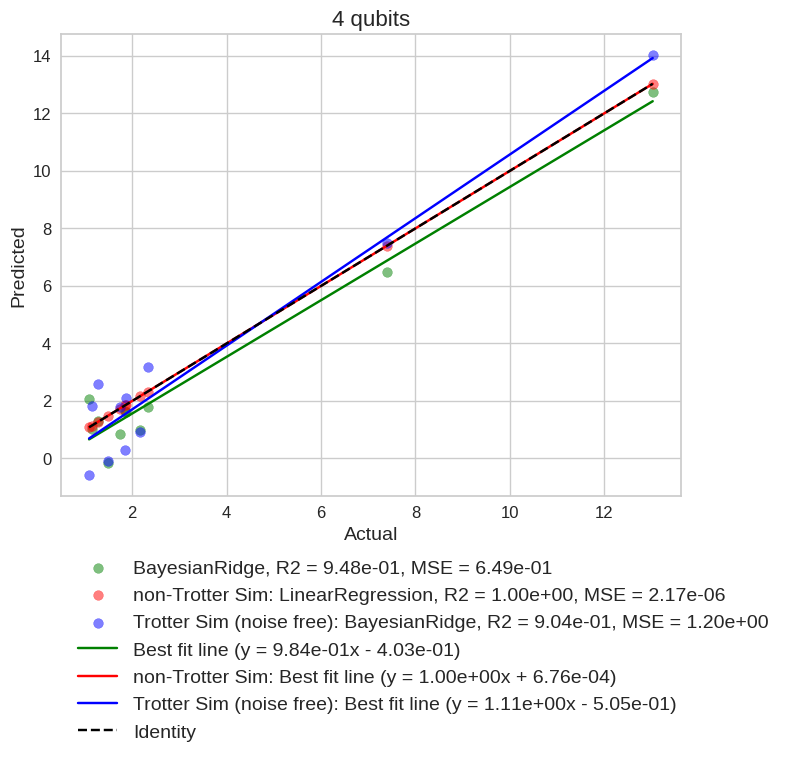

In [49]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=feature_sim_noisy_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)
create_model_and_plot(s_sim_noisy, s_exact, s_sim_noiseless)

In [33]:
# これと同じ予測を上のセルでは行なっている
# best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort=sort)
# s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 21)"
4,Transformed data shape,"(56, 20)"
5,Transformed train set shape,"(44, 20)"
6,Transformed test set shape,"(12, 20)"
7,Ignore features,2
8,Numeric features,19
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.9522,1.5694,1.2528,0.7808,0.2936,0.5589


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0161,0.0004,0.0211,0.9999,0.0059,0.0143


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.9319,1.4199,1.1916,0.8017,0.3189,0.5930


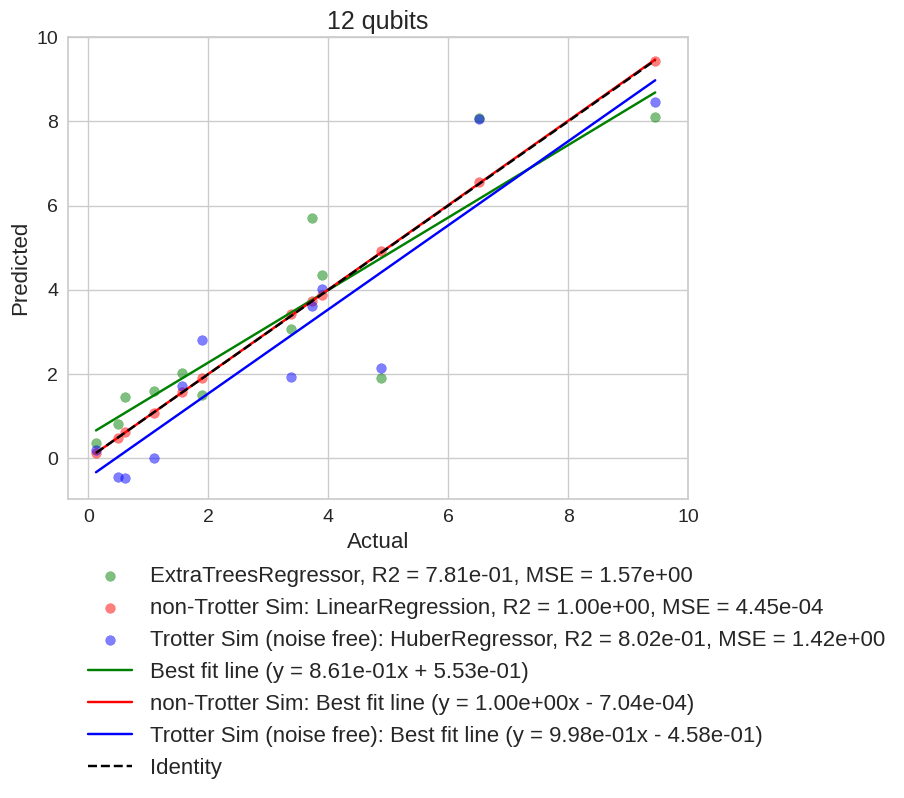

In [34]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)
create_model_and_plot(s_nmit, s_exact, s_sim)

In [35]:
# これと同じ予測を上のセルでは行なっている
# best_nmit = s_nmit.compare_models(turbo=True, sort=sort)
# s_nmit.plot_model(best_nmit, plot="error")

In [42]:
# create_model_and_plot(s_nmit, s_exact, s_sim, reg_method="et")

In [40]:
# # model_nmit = s_nmit.compare_models(turbo=True, sort="R2")
# model_nmit = s_nmit.create_model("et")
# s_nmit.plot_model(model_nmit, plot="error")
# s_nmit.tune_model(model_nmit, optimize=sort, choose_better=True)
# prod = s_nmit.predict_model(model_nmit)
# x = prod["expected_value"].values.reshape(-1, 1)  # サンプル数 x 1
# y = prod["prediction_label"].values
# r2 = r2_score(x, y)
# mse = mean_squared_error(x, y)

# # 回帰手法の名前を取得
# reg_method = model_nmit.__class__.__name__

# # 回帰直線を計算
# linear_model = LinearRegression()
# linear_model.fit(x, y)
# slope = linear_model.coef_[0]
# intercept = linear_model.intercept_

# # プロット
# plt.figure(figsize=(8, 6))
# plt.scatter(
#     x,
#     y,
#     color="green",
#     alpha=0.5,
#     label=f"{reg_method}, R2 = {r2:.2f}, MSE = {mse:.2f}",
# )

# # 回帰直線を追加
# x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
# plt.plot(
#     x_range,
#     linear_model.predict(x_range),
#     color="green",
#     label=f"Best fit line (y = {slope:.2f}x + {intercept:.2f})",
# )

# # Identity line
# plt.plot([x.min(), x.max()], [x.min(), x.max()], "--", color="black", label="Identity")

# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.legend()
# plt.title(f"{n_qubits}Q - Predicted vs Actual")
# plt.show()

## Trotter (QPU, mitigation)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(56, 21)"
4,Transformed data shape,"(56, 20)"
5,Transformed train set shape,"(44, 20)"
6,Transformed test set shape,"(12, 20)"
7,Ignore features,2
8,Numeric features,19
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.3698,0.2117,0.4601,0.7755,0.1288,0.1674


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.1910,0.4075,0.6384,0.5678,0.1579,0.0922


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.3382,0.2762,0.5256,0.7070,0.1420,0.1651


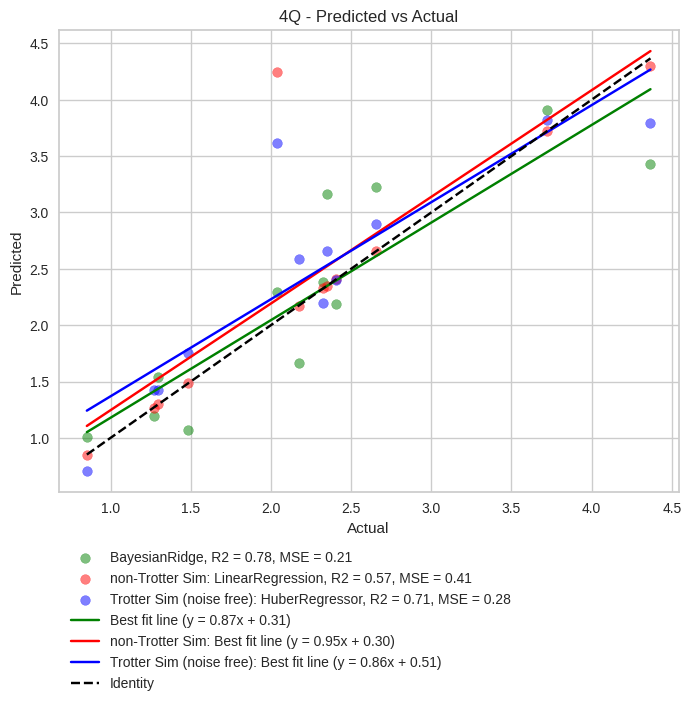

In [41]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)
create_model_and_plot(s_mit, s_exact, s_sim)

In [42]:
# create_model_and_plot(s_mit, s_exact, s_sim, reg_method="et")

In [43]:
# model_mit = s_mit.compare_models(turbo=True, sort=sort)
# s_mit.plot_model(model_mit, plot="error")
# s_mit.tune_model(model_mit, optimize=sort, choose_better=True)
# prod = s_mit.predict_model(model_mit)
# x = prod["expected_value"].values.reshape(-1, 1)  # サンプル数 x 1
# y = prod["prediction_label"].values
# r2 = r2_score(x, y)
# mse = mean_squared_error(x, y)

# # 回帰直線を計算
# linear_model = LinearRegression()
# linear_model.fit(x, y)
# slope = linear_model.coef_[0]
# intercept = linear_model.intercept_

# # プロット
# plt.figure(figsize=(8, 6))
# plt.scatter(x, y, alpha=0.5, label=f"R2 = {r2:.2f}, MSE = {mse:.2f}")

# # 回帰直線を追加
# x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
# plt.plot(
#     x_range,
#     linear_model.predict(x_range),
#     color="red",
#     label=f"Best fit line (y = {slope:.2f}x + {intercept:.2f})",
# )

# # Identity line
# plt.plot([x.min(), x.max()], [x.min(), x.max()], "--", color="black", label="Identity")

# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.legend()
# plt.title(f"Predicted vs Actual for {model_nmit.__class__.__name__}")
# plt.show()